# 170671 Shivam Pandey
# CE678A Lab4

### Q1. Parse data file to retrieve all the columns of information as well as the header information. Give a short description (1-2 short sentences) of the technical terms in the header of the data file.

In [2]:
# Open File to read
s= fopen('GravimeterData.dat','r');

# Specify column datatype and read them 
# skip Header information
file = textscan(s,'%s %s %s %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %d','headerlines',19);

#### Header Information from file

```/		CG-6 Survey
/		Survey Name:	AUTUMN
/		Created:	2019-10-18 09:33:06
/
/		CG-6 Calibration
/		Operator:	STUDENTS
/		Gcal1 [mGal]:	8254.132000
/		Goff [ADU]:	-8388608.000000
/		Gref [mGal]:	0.0000
/		X Scale [arc-sec/ADU]:	0.030719
/		Y Scale [arc-sec/ADU]:	0.030678
/		X Offset [ADU]:	-198512.244748
/		Y Offset [ADU]:	-152741.110754
/		Temperature Coefficient [mGal/mK]:	-0.131300
/		Drift Rate [mGal/day]:	-0.011726
/		Drift Zero Time:	2017-04-07 12:00:00
/		Firmware Version:	20170126-1```

#### The header information contains date and name given to survey.
#### Also from the skipped line it contains the calibration information and the corresctions related to spcific environment and date-time
#### The calibration information also has the offset from center as X and Y, temprature  coefficient to get the effect of temprature on corrections and the drift time zero setting that may not be needed as we conpare it relative whose difference will be cancelling out this as a bias.
#### Some information about the software that has been used, usefull to get the data transformaed to a newer date.

In [3]:
# Extract out time information of the day
time = [];

for i = 1:size(file{1, 3})
    time = [time; cellfun(@(x) str2num(x), (strsplit(file{1, 3}{i, 1}, ":")))];
endfor

# Cnvert to hours
time = time(:, 1).+time(:, 2)./60.+time(:, 3)./3600;

In [4]:
# get all the remaining data as a matrix 
# easy to operate
data = [];

# set format for the precision
format long;
for j = 4:size(file)(2)
    data_tmp = [];
    
    # convert data to double precision
    # as the concatenation will make it integet if done so
    for i = 1:size(file{1, j})
        data_tmp = [data_tmp; double(file{1, j}(i, 1))];
    endfor
    
    # concatenate the data
    data = [data, data_tmp];
endfor

# combine data with time
data = [double(time), data];
disp("The complete data except Station name and date:-\n"), disp(data(1:10));

The complete data except Station name and date:-

 Columns 1 through 3:

   9.551666666666668e+00   9.568333333333333e+00   9.585000000000001e+00

 Columns 4 through 6:

   9.791111111111110e+00   9.807777777777778e+00   9.824444444444444e+00

 Columns 7 through 9:

   9.939444444444444e+00   9.956111111111110e+00   9.972777777777777e+00

 Column 10:

   1.001555555555556e+01


In [5]:
# define function for gravity adjustment 
function [adjusted_absolute_gravity, adjusted_relative_gravity, gravity_diff_drift, gravity_variances, other_params] = gravity_adjust(GPs, y, t, std_obs)
    
    # sort the ground points to get the sequence
    [GPs_visited, i, j] = unique(GPs, "first");
    [_, sorted_idx] = sort(i);
    
    # find the unique visited ground points
    GPs_visited = GPs_visited(sorted_idx);
    
    # get the matrix A and set the size
    n = size(GPs_visited)(2);
    m = size(GPs)(2)-1;
    A = zeros(m, n);
    
    # fill the design matrix
    GP_id = 1;
    for gp = GPs
        if (GP_id >=2)
            idx_itr = 1;
            for gpv = GPs_visited
                if (strcmpi(gp, gpv))
                    if(idx_itr ~= 1)
                       A(GP_id-1, idx_itr-1) = 1;
                    end 
                endif
                idx_itr +=1;
            endfor
        endif
        GP_id = GP_id+1;
    endfor
    
    # get the difference elements
    y1 = y(1, 1);
    t1 = t(1, 1);
    std_obs1 = std_obs(1, 1);
    
    # define L, and fill the rest of the design matrix
    y_res = y(2:end, 1) .- y1;
    t_res = t(2:end, 1) .- t1;
    std_obs_res = (std_obs(2:end, 1)).^2 .+ std_obs1^2;
    
    # reference variance to be 1
    ref_var = 1;
    
    # get the weight matrix P
    A(:, end) = t_res;
    P = inv(diag(std_obs_res));
    
    # adjust the OEM 
    [adjusted_relative_gravity, gravity_diff_drift, gravity_variances, other_params] = adjust_observation_equations(A, y_res, P);
    
    # get the adjusted absolute value
    adjusted_absolute_gravity = [y1; adjusted_relative_gravity.+y1];
    
    return;
endfunction

In [6]:
function [adjusted_values, estimated_params, variances, other_params] = adjust_observation_equations(A, L, P)
    
    # define the N matrix
    N = A'*P*A;
    
    # define the U matrix
    U = A'*P*L;
    
    # get the parameter estimate 
    # the last one is drift parameter
    estimated_params = inv(N)*U;
    
    # asjusted value
    adjusted_values = A*estimated_params;
    
    # residual vector
    V = adjusted_values .- L;
    
    # define the other elements
    [n, u] = size(A);
    
    # DOF
    r = n-u;
    
    # define variance matrix
    sigma_xx = inv(N);
    sigma_vv = inv(P) .- A*inv(N)*A';
    sigma_lala = A*inv(N)*A';
    variances = {{"sigma_xx", sigma_xx},
                 {"sigma_vv", sigma_vv},
                 {"sigma_lala", sigma_lala}};
    other_params = {{"sigma_o", 1},
                    {"n", n},
                    {"u", u},
                    {"r", (n - u)},
                    {"sigma_hat_o", (V'*P*V)/r},
                    {"A", A},
                    {"P", P}};
    return;
endfunction

In [7]:
GPs = {"GF1", "FF1", "SF1", "FF2", "GF2", "15", "18", "16", "GF3", "GF4", "18_2", "GF5"};
GPs_core = {"GF", "FF", "SF", "FF", "GF", "15", "18", "16", "GF", "GF", "18", "GF"};

In [8]:
# get the relevent data to adjustment
relevent_data = [];
for i = GPs
    data_tmp = [];
    for j = 1:size(file{1, 1})(1)
        if (strcmpi(i{1, 1}, file{1, 1}{j, 1}))
            data_tmp = [data_tmp; data(j, [1, 2, 3, 4, 20])];
        endif
    endfor
    
    # get the mean of the data
    # variance will follow variance propagation law
    avg_data = [mean(data_tmp(:, 1)), mean(data_tmp(:, 2)), sqrt(mean((data_tmp(:, 3)).^2)), sqrt(mean((data_tmp(:, 4)).^2)), mean(data_tmp(:, 5))];
    relevent_data = [relevent_data; avg_data];
endfor

In [9]:
# got the relevent data time, gravity reading, std dev, std error, Height
disp("reevent data to adjustment and estimation process:- "), disp(relevent_data(1:5, :));

reevent data to adjustment and estimation process:- 
 Columns 1 through 3:

   9.568333333333333e+00   2.690362900000000e+03   1.575822325010025e-01
   9.807777777777778e+00   2.689276400000000e+03   1.033816553681874e-01
   9.994166666666667e+00   2.688167583333333e+03   9.313674534432334e-02
   1.017333333333333e+01   2.689264633333333e+03   1.270033332895900e-01
   1.026583333333333e+01   2.690306366666667e+03   1.532054502946942e-01

 Columns 4 and 5:

   2.031592150670668e-02   1.095000000000000e+02
   1.332641487172500e-02   1.095000000000000e+02
   1.201734857057358e-02   1.095000000000000e+02
   1.637660933567548e-02   1.095000000000000e+02
   1.978560082484230e-02   1.095000000000000e+02


### Q4. Perform the adjustment for the vertical and the horizontal network together and compare the results with the separate adjustments of the vertical and the horizontal networks
### Q5. Use the standard deviations of the individual measurements for constructing the weight matrix of the adjustment.
### Q6. Calculate variance-covariance information for all estimated quantities.
### Q7. Calculate a priori reference variance, n, u, r, and a posteriori reference variance.

### Using standard deviation to estimate weight matrix

In [10]:
# vertical adjustment network
gp_vertical = {"GF", "FF", "SF", "FF", "GF"};
[adjusted_absolute_gravity_vertical, adjusted_relative_gravity_vertical, gravity_diff_drift_vertical, gravity_variances_vertical, other_params_vertical] = gravity_adjust(gp_vertical, 
                                                                                                                                                            relevent_data(1:5, 2), 
                                                                                                                                                            relevent_data(1:5, 1), 
                                                                                                                                                            relevent_data(1:5, 3));

disp("Displaying the information about the vertical gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_vertical);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_vertical);

Displaying the information about the vertical gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

       3.319228115815092e-02   1.474393727477478e-02  -3.462372745543980e-02
       1.474393727477478e-02   4.884924407039889e-02  -3.602966122207173e-02
      -3.462372745543980e-02  -3.602966122207173e-02   8.460977195007062e-02

  }

  [2,1] =
  {
    [1,1] = sigma_vv
    [1,2] =

     Columns 1 through 3:

       1.405757750624519e-02   4.355713512522169e-19  -1.621136746513548e-02
      -2.107159419773504e-19   0.000000000000000e+00  -6.945139369099726e-19
      -1.621136746513548e-02   3.163094325417056e-19   1.869514395157337e-02
       1.001916036235808e-02  -2.929060534968441e-18  -1.155421624061108e-02

     Column 4:

       1.001916036235808e-02
      -9.231130435226588e-19

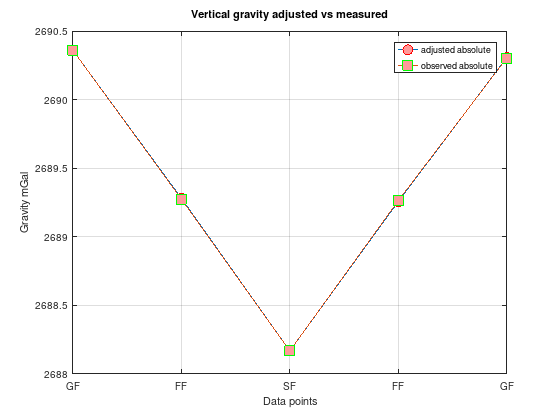

In [11]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_vertical, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(1:5, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_vertical;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:5],'xticklabel',x);
grid();
title("Vertical gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

In [12]:
# horizontal adjustment network
gp_horizontal = {"GF", "15", "18", "16", "GF", "GF", "18", "GF"};
[adjusted_absolute_gravity_horizontal, adjusted_relative_gravity_horizontal, gravity_diff_drift_horizontal, gravity_variances_horizontal, other_params_horizontal] = gravity_adjust(gp_horizontal, 
                                                                                                                                                            relevent_data(5:end, 2), 
                                                                                                                                                            relevent_data(5:end, 1), 
                                                                                                                                                            relevent_data(5:end, 3));
                                                                                                                                                            
disp("Displaying the information about the horizontal gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_horizontal);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_horizontal);

Displaying the information about the horizontal gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

     Columns 1 through 3:

       3.041455592017970e-02   1.429061920393647e-03   1.186081508474279e-03
       1.429061920393647e-03   1.765533219110697e-02   4.604213149664179e-03
       1.186081508474279e-03   4.604213149664179e-03   3.059246340955536e-02
      -1.292340626666891e-03  -5.016697136437968e-03  -4.163718606053058e-03

     Column 4:

      -1.292340626666891e-03
      -5.016697136437968e-03
      -4.163718606053058e-03
       4.536739401268465e-03

  }

  [2,1] =
  {
    [1,1] = sigma_vv
    [1,2] =

     Columns 1 through 3:

       0.000000000000000e+00   1.402327924545838e-19   5.443364166477535e-20
       1.016124402536907e-19   1.018178339094891e-02  -4.438033638

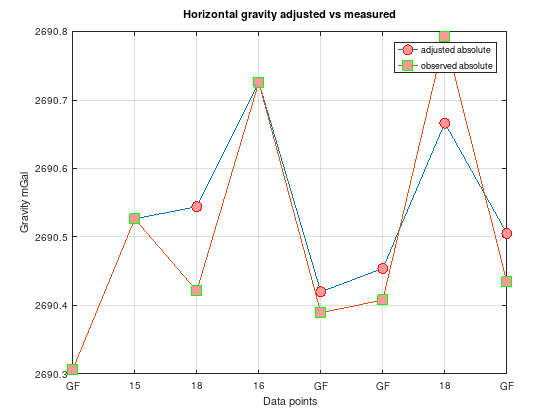

In [13]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_horizontal, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(5:end, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_horizontal;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:8],'xticklabel',x);
grid();
title("Horizontal gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

In [14]:
# commplete adjustment network
gp_complete = {"GF", "FF", "SF", "FF", "GF", "15", "18", "16", "GF", "GF", "18", "GF"};
[adjusted_absolute_gravity_complete, adjusted_relative_gravity_complete, gravity_diff_drift_complete, gravity_variances_complete, other_params_complete] = gravity_adjust(gp_complete, 
                                                                                                                                                relevent_data(1:end, 2), 
                                                                                                                                                relevent_data(1:end, 1), 
                                                                                                                                                relevent_data(1:end, 3));
                                                                                                                                                
disp("Displaying the information about the complete gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_complete);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_complete);

Displaying the information about the complete gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

     Columns 1 through 3:

       1.942483388417296e-02   4.174479673322997e-04   9.630167883044212e-04
       4.174479673322997e-04   3.394101222525456e-02   1.002121122817599e-03
       9.630167883044212e-04   1.002121122817599e-03   3.371847612905705e-02
       1.768162266556184e-03   1.839960400903074e-03   4.244631414085923e-03
       1.583470273996949e-03   1.647768790947077e-03   3.801261793336163e-03
      -9.803083381580424e-04  -1.020114814687787e-03  -2.353317705246808e-03

     Columns 4 through 6:

       1.768162266556184e-03   1.583470273996949e-03  -9.803083381580424e-04
       1.839960400903074e-03   1.647768790947077e-03  -1.020114814687787e-03
       4.24463141408592

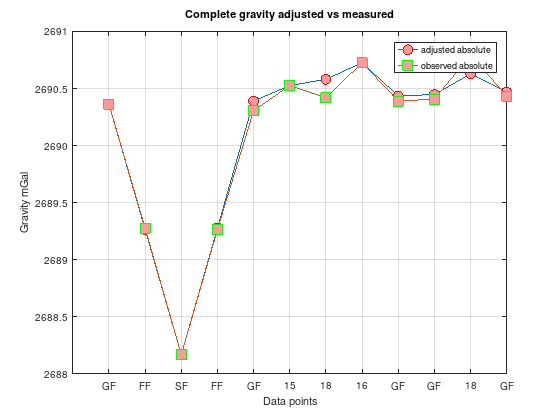

In [15]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_complete, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(1:end, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_complete;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:12],'xticklabel',x);
grid();
title("Complete gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

### Q8. Report the stability of the design matrix (Hint: Use the eigenvalues and the condition number).

\begin{equation}
\begin{split}
    & Condition\quad number\quad can\quad provide\quad the\quad stability\quad of\quad matrices\\
    & \kappa(A) = \frac{\sigma_{max}(A)}{\sigma_{min}(A)}\\
    & \sigma\quad is\quad the\quad singular\quad values\quad for\quad matrix\quad A\\
    & \sigma = svd(A)\\
\end{split}
\end{equation}

In [16]:
## for vertical adjustment alone

# get the SVD for matrix A especially the singular values s
s_v = svd(other_params_vertical{6}{1, 2});
k_v = max(s_v)/min(s_v);
disp("The condition number of vertical-net design matrix:- "), disp(k_v);

## for horizontal adjustment alone

# get the SVD for matrix A especially the singular values s
s_h = svd(other_params_horizontal{6}{1, 2});
k_h = max(s_h)/min(s_h);
disp("The condition number of horizontal-net design matrix:- "), disp(k_h);

## for complete adjustment alone

# get the SVD for matrix A especially the singular values s
s_c = svd(other_params_complete{6}{1, 2});
k_c = max(s_c)/min(s_c);
disp("The condition number of complete-net design matrix:- "), disp(k_c);

The condition number of vertical-net design matrix:- 
 2.627032914176620
The condition number of horizontal-net design matrix:- 
 3.761229557991229
The condition number of complete-net design matrix:- 
 6.074506217755021


### ANS:- The stability of the design matrix for complete network is larget so having largest stability and for the vertical-net its the lowest therefore having lowest stability.

### Q9. Show adjusted gravity value at each point and compare it with the observed gravity values. Compare the vertical gravity gradient with the theoretical value of the free-air gravity gradient.

`adjusted vs observed cmparison is shown above against each type of adjustment similar for the rest`

In [18]:
h_Groundfloor =  128.409; #m (above MSL)
h_Firstfloor = 132.142; #m
h_Secondfloor = 135.845; #m

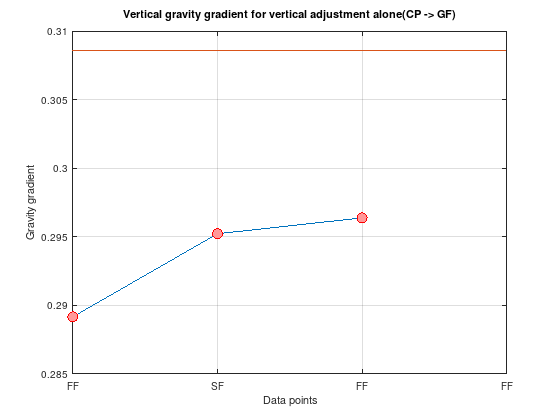

In [19]:
height = [h_Firstfloor - h_Groundfloor, h_Secondfloor - h_Groundfloor, h_Firstfloor - h_Groundfloor]'; #mt
plot(abs(adjusted_relative_gravity_vertical(1:3))./height, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(abs(adjusted_relative_gravity_vertical).*0+0.3086);
x = gp_vertical(2:4);
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:4],'xticklabel',x);
grid();
title("Vertical gravity gradient for vertical adjustment alone(CP -> GF)");
xlabel("Data points");
ylabel("Gravity gradient");

### Q10. Repeat the estimation of gravity values using standard error as information for the weight matrix. You will have to square the values to get the variance-type information. Compare the results with the results from the adjustment with standard deviation as weights for the data.

### Using the standard error for estimation

In [20]:
# vertical adjustment network
gp_vertical = {"GF", "FF", "SF", "FF", "GF"};
[adjusted_absolute_gravity_vertical, adjusted_relative_gravity_vertical, gravity_diff_drift_vertical, gravity_variances_vertical, other_params_vertical] = gravity_adjust(gp_vertical, 
                                                                                                                                                            relevent_data(1:5, 2), 
                                                                                                                                                            relevent_data(1:5, 1), 
                                                                                                                                                            relevent_data(1:5, 4));

disp("Displaying the information about the vertical gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_vertical);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_vertical);

Displaying the information about the vertical gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

       5.520109405318684e-04   2.453978440682304e-04  -5.762767375379189e-04
       2.453978440682304e-04   8.125286844372925e-04  -5.997072824359114e-04
      -5.762767375379189e-04  -5.997072824359114e-04   1.408314557579440e-03

  }

  [2,1] =
  {
    [1,1] = sigma_vv
    [1,2] =

     Columns 1 through 3:

       2.335477833673049e-04   5.142387184723869e-20  -2.693911746451967e-04
       4.771489652643779e-20   0.000000000000000e+00   4.988620880866801e-21
      -2.693911746451967e-04   2.047102790395956e-20   3.107355759510000e-04
       1.667468893849620e-04  -1.370605208214850e-19  -1.923381149338542e-04

     Column 4:

       1.667468893849620e-04
      -8.152407153953583e-20

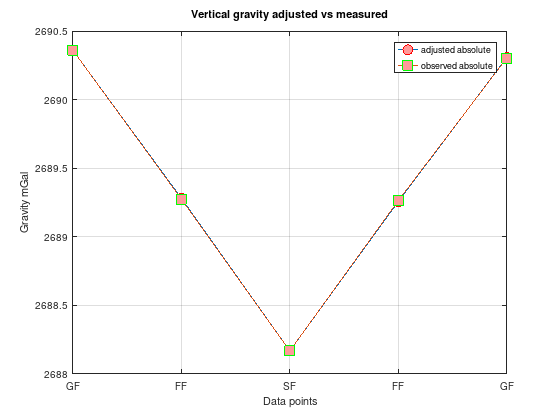

In [21]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_vertical, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(1:5, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_vertical;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:5],'xticklabel',x);
grid();
title("Vertical gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

In [22]:
# horizontal adjustment network
gp_horizontal = {"GF", "15", "18", "16", "GF", "GF", "18", "GF"};
[adjusted_absolute_gravity_horizontal, adjusted_relative_gravity_horizontal, gravity_diff_drift_horizontal, gravity_variances_horizontal, other_params_horizontal] = gravity_adjust(gp_horizontal, 
                                                                                                                                                            relevent_data(5:end, 2), 
                                                                                                                                                            relevent_data(5:end, 1), 
                                                                                                                                                            relevent_data(5:end, 4));

disp("Displaying the information about the horizontal gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_horizontal);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_horizontal);

Displaying the information about the horizontal gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

     Columns 1 through 3:

       5.072654730926816e-04   2.382981788467578e-05   1.977827053296182e-05
       2.382981788467577e-05   2.944395223783772e-04   7.677593202434790e-05
       1.977827053296182e-05   7.677593202434794e-05   5.100841492028989e-04
      -2.155017370419569e-05  -8.365416322265518e-05  -6.943127637119709e-05

     Column 4:

      -2.155017370419569e-05
      -8.365416322265515e-05
      -6.943127637119709e-05
       7.565151178459735e-05

  }

  [2,1] =
  {
    [1,1] = sigma_vv
    [1,2] =

     Columns 1 through 3:

       0.000000000000000e+00  -6.156113142945649e-22   2.110095015170003e-22
      -2.492402084199963e-21   1.698109655013266e-04   1.596031173

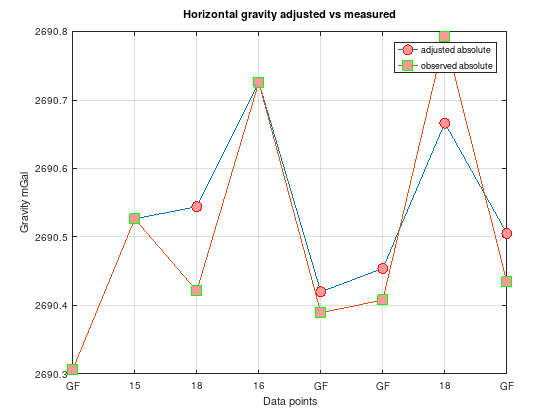

In [23]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_horizontal, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(5:end, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_horizontal;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:8],'xticklabel',x);
grid();
title("Horizontal gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

In [24]:
# complete adjustment network
gp_complete = {"GF", "FF", "SF", "FF", "GF", "15", "18", "16", "GF", "GF", "18", "GF"};
[adjusted_absolute_gravity_complete, adjusted_relative_gravity_complete, gravity_diff_drift_complete, gravity_variances_complete, other_params_complete] = gravity_adjust(gp_complete, 
                                                                                                                                                relevent_data(1:end, 2), 
                                                                                                                                                relevent_data(1:end, 1), 
                                                                                                                                                relevent_data(1:end, 4));

disp("Displaying the information about the complete gravimetry:-\n");
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Variance information for eastimation:- "), disp(gravity_variances_complete);
disp("_____________________________________________________________________________");
disp("_____________________________________________________________________________");
disp("Other estimates containing sigma_o, n, u, r, and sigma_hat_o:- "), disp(other_params_complete);

Displaying the information about the complete gravimetry:-

_____________________________________________________________________________
_____________________________________________________________________________
Variance information for eastimation:- 
{
  [1,1] =
  {
    [1,1] = sigma_xx
    [1,2] =

     Columns 1 through 3:

       3.228744957325860e-04   6.945056255392442e-06   1.602165130280193e-05
       6.945056255392442e-06   5.643807651243173e-04   1.667306753347285e-05
       1.602165130280193e-05   1.667306753347285e-05   5.608566753634228e-04
       2.941627107571853e-05   3.061229238852712e-05   7.061994261710771e-05
       2.634409792896741e-05   2.741520930500343e-05   6.324454514490842e-05
      -1.630932975826014e-05  -1.697244256199697e-05  -3.915397463829241e-05

     Columns 4 through 6:

       2.941627107571852e-05   2.634409792896741e-05  -1.630932975826014e-05
       3.061229238852710e-05   2.741520930500343e-05  -1.697244256199697e-05
       7.06199426171076

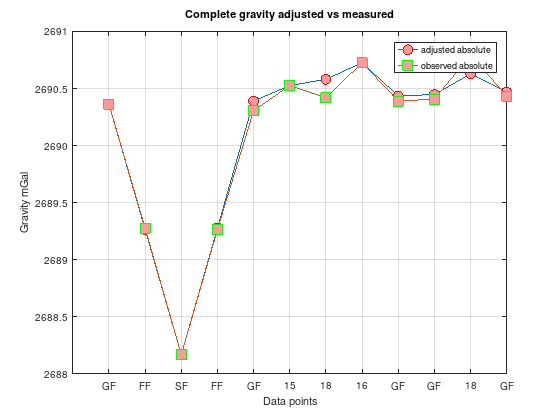

In [25]:
# compare measured vs adjusted gravity
plot(adjusted_absolute_gravity_complete, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(relevent_data(1:end, 2), '-s','MarkerSize',10,...
                    'MarkerEdgeColor','green',...
                    'MarkerFaceColor',[1 .6 .6]);
x = gp_complete;
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:12],'xticklabel',x);
grid();
title("Complete gravity adjusted vs measured");
xlabel("Data points");
ylabel("Gravity mGal");
legend("adjusted absolute", "observed absolute");
hold off;

In [26]:
## for vertical adjustment alone

# get the SVD for matrix A especially the singular values s
s_v = svd(other_params_vertical{6}{1, 2});
k_v = max(s_v)/min(s_v);
disp("The condition number of vertical-net design matrix:- "), disp(k_v);

## for horizontal adjustment alone

# get the SVD for matrix A especially the singular values s
s_h = svd(other_params_horizontal{6}{1, 2});
k_h = max(s_h)/min(s_h);
disp("The condition number of horizontal-net design matrix:- "), disp(k_h);

## for complete adjustment alone

# get the SVD for matrix A especially the singular values s
s_c = svd(other_params_complete{6}{1, 2});
k_c = max(s_c)/min(s_c);
disp("The condition number of complete-net design matrix:- "), disp(k_c);

The condition number of vertical-net design matrix:- 
 2.627032914176620
The condition number of horizontal-net design matrix:- 
 3.761229557991229
The condition number of complete-net design matrix:- 
 6.074506217755021


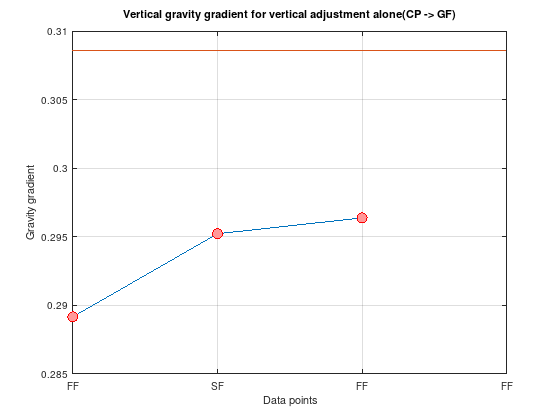

In [27]:
height = [h_Firstfloor - h_Groundfloor, h_Secondfloor - h_Groundfloor, h_Firstfloor - h_Groundfloor]'; #mt
plot(abs(adjusted_relative_gravity_vertical(1:3))./height, '-o','MarkerSize',10,...
                                        'MarkerEdgeColor','red',...
                                        'MarkerFaceColor',[1 .6 .6]);
hold on;
plot(abs(adjusted_relative_gravity_vertical).*0+0.3086);
x = gp_vertical(2:4);
% xticklabels(x);
% disp(abs(adjusted_relative_gravity_vertical(1:3))./height);
set(gca,'xtick',[1:4],'xticklabel',x);
grid();
title("Vertical gravity gradient for vertical adjustment alone(CP -> GF)");
xlabel("Data points");
ylabel("Gravity gradient");